# Retina Face

## Sample Detection

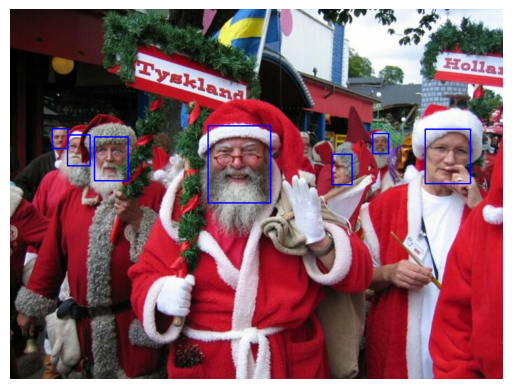

In [2]:
import cv2
from retinaface import RetinaFace
import matplotlib.pyplot as plt

image_path = "Data/WIDER FACE Validation Set/images/0--Parade/0_Parade_Parade_0_519.jpg"
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

results = RetinaFace.detect_faces(image_rgb)

for key, face in results.items():
    facial_area = face['facial_area']
    x1, y1, x2, y2 = facial_area
    cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

## Defining the Metrics

### Intersection Over Union (IOU)

In [3]:
def calc_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = max(box1[2], box2[2])
    y2 = max(box1[3], box2[3])

    intersection = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)

    box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)

    union = box1_area + box2_area - intersection

    return intersection / union

### Precision

In [4]:
def calc_precision(true_positives, false_positives):
    if true_positives + false_positives > 0:
        return true_positives / (true_positives + false_positives)
    else:
        return 0

### Recall

In [5]:
def calc_recall(true_positives, false_negatives):
    if true_positives + false_negatives > 0:
        return true_positives / (true_positives + false_negatives)
    else:
        return 0

### F1 Score

In [6]:
def calc_f1_score(precision, recall):
    if precision + recall > 0:
        return (2 * precision * recall) / (precision + recall)
    else:
        return 0

### Method to Compute the Metrics

In [7]:
def evaluate_predictions(predictions, ground_truth, iou_threshold=0.5):
    true_positives = 0
    false_positives = 0
    false_negatives = 0

    matched = [False] * len(ground_truth)

    for pred in predictions:
        matched_any = False
        for i, gt in enumerate(ground_truth):
            if not matched[i] and calc_iou(pred, gt) >= iou_threshold:
                matched[i] = True
                matched_any = True
                true_positives += 1
                break
        if not matched_any:
            false_positives += 1
    false_negatives = len(ground_truth) - sum(matched)

    precision = calc_precision(true_positives, false_positives)
    recall = calc_recall(true_positives, false_negatives)
    f1_score = calc_f1_score(precision, recall)

    return precision, recall, f1_score

## Computing for WIDERFACE Dataset on the Number of Faces

In [10]:
import json
import cv2
from retinaface import RetinaFace
import numpy as np

def evaluate_retinaface_with_predictions(json_path, output_path, predictions_output_path):
    """
    Evaluate RetinaFace model on a subset of images from the given JSON annotation file,
    and save the model's predictions in a separate JSON file.

    Args:
        json_path (str): Path to the JSON file containing annotations.
        output_path (str): Path to save the evaluation metrics as a JSON file.
        predictions_output_path (str): Path to save the model predictions as a JSON file.

    Returns:
        None: Prints mean precision, recall, and F1-score, saves metrics and predictions to JSON files.
    """
    # Load the annotations
    with open(json_path, 'r') as json_file:
        annotations = json.load(json_file)

    # Initialize the RetinaFace model
    retinaface_model = RetinaFace.build_model()

    # Metrics for all images
    precision_scores = []
    recall_scores = []
    f1_scores = []

    # Store predictions
    predictions_data = []

    for index, image_annotation in enumerate(annotations):
        # Track progress
        print(f"Processing image ({index + 1}/{len(annotations)}) ...")

        # Convert ground truths to bbox format (x, y, x+w, y+h)
        ground_truths = [
            [int(gt['bbox'][0]), int(gt['bbox'][1]), int(gt['bbox'][0] + gt['bbox'][2]), int(gt['bbox'][1] + gt['bbox'][3])]
            for gt in image_annotation['image_info']
        ]

        # Load the image
        image_path = image_annotation['image_path']
        image = cv2.imread(image_path)
        if image is None:
            print(f"Error: Could not load image at {image_path}")
            continue

        # Get predictions
        results = RetinaFace.detect_faces(image, model=retinaface_model)
        predictions = []
        for key, face in results.items():
            x1, y1, x2, y2 = face['facial_area']
            predictions.append([int(x1), int(y1), int(x2), int(y2)])  # Ensure conversion to int

        # Save predictions for this image
        predictions_data.append({
            "image_path": image_path,
            "predicted_boxes": predictions
        })

        # Calculate metrics
        precision, recall, f1_score = evaluate_predictions(predictions, ground_truths)
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1_score)

    # Calculate mean metrics
    mean_precision = sum(precision_scores) / len(precision_scores) if precision_scores else 0
    mean_recall = sum(recall_scores) / len(recall_scores) if recall_scores else 0
    mean_f1 = sum(f1_scores) / len(f1_scores) if f1_scores else 0

    # Print the results
    print(f"Mean Precision: {mean_precision:.4f}")
    print(f"Mean Recall: {mean_recall:.4f}")
    print(f"Mean F1-Score: {mean_f1:.4f}")

    # Save metrics to a JSON file
    output_data = {
        "mean_precision": mean_precision,
        "mean_recall": mean_recall,
        "mean_f1_score": mean_f1,
        "individual_scores": {
            "precision_scores": [float(p) for p in precision_scores],  # Convert to float
            "recall_scores": [float(r) for r in recall_scores],        # Convert to float
            "f1_scores": [float(f) for f in f1_scores]                # Convert to float
        }
    }
    with open(output_path, 'w') as output_file:
        json.dump(output_data, output_file, indent=4)
    print(f"Metrics saved to {output_path}")

    # Save predictions to a separate JSON file
    with open(predictions_output_path, 'w') as pred_file:
        json.dump(predictions_data, pred_file, indent=4)
    print(f"Predictions saved to {predictions_output_path}")

### Easy Number of Faces

In [14]:
json_path = "Data/WIDER FACE Validation Set/wider_face_num_faces_easy.json"
output_path_metrics = "Outputs/metrics_easy_num_faces.json"
output_path_predictions = "Outputs/predictions_easy_num_faces.json"

evaluate_retinaface_with_predictions(json_path, output_path_metrics, output_path_predictions)

Processing image (1/1122) ...
Processing image (2/1122) ...
Processing image (3/1122) ...
Processing image (4/1122) ...
Processing image (5/1122) ...
Processing image (6/1122) ...
Processing image (7/1122) ...
Processing image (8/1122) ...
Processing image (9/1122) ...
Processing image (10/1122) ...
Processing image (11/1122) ...
Processing image (12/1122) ...
Processing image (13/1122) ...
Processing image (14/1122) ...
Processing image (15/1122) ...
Processing image (16/1122) ...
Processing image (17/1122) ...
Processing image (18/1122) ...
Processing image (19/1122) ...
Processing image (20/1122) ...
Processing image (21/1122) ...
Processing image (22/1122) ...
Processing image (23/1122) ...
Processing image (24/1122) ...
Processing image (25/1122) ...
Processing image (26/1122) ...
Processing image (27/1122) ...
Processing image (28/1122) ...
Processing image (29/1122) ...
Processing image (30/1122) ...
Processing image (31/1122) ...
Processing image (32/1122) ...
Processing image 

### Medium Number of Faces

In [12]:
json_path = "Data/WIDER FACE Validation Set/wider_face_num_faces_medium.json"
output_path_metrics = "Outputs/metrics_medium_num_faces.json"
output_path_predictions = "Outputs/predictions_medium_num_faces.json"

evaluate_retinaface_with_predictions(json_path, output_path_metrics, output_path_predictions)

Processing image (1/1089) ...
Processing image (2/1089) ...
Processing image (3/1089) ...
Processing image (4/1089) ...
Processing image (5/1089) ...
Processing image (6/1089) ...
Processing image (7/1089) ...
Processing image (8/1089) ...
Processing image (9/1089) ...
Processing image (10/1089) ...
Processing image (11/1089) ...
Processing image (12/1089) ...
Processing image (13/1089) ...
Processing image (14/1089) ...
Processing image (15/1089) ...
Processing image (16/1089) ...
Processing image (17/1089) ...
Processing image (18/1089) ...
Processing image (19/1089) ...
Processing image (20/1089) ...
Processing image (21/1089) ...
Processing image (22/1089) ...
Processing image (23/1089) ...
Processing image (24/1089) ...
Processing image (25/1089) ...
Processing image (26/1089) ...
Processing image (27/1089) ...
Processing image (28/1089) ...
Processing image (29/1089) ...
Processing image (30/1089) ...
Processing image (31/1089) ...
Processing image (32/1089) ...
Processing image 

### Hard Number of Faces

In [11]:
json_path = "Data/WIDER FACE Validation Set/wider_face_num_faces_hard.json"
output_path_metrics = "Outputs/metrics_hard_num_faces.json"
output_path_predictions = "Outputs/predictions_hard_num_faces.json"

evaluate_retinaface_with_predictions(json_path, output_path_metrics, output_path_predictions)

Processing image (1/1015) ...
Processing image (2/1015) ...
Processing image (3/1015) ...
Processing image (4/1015) ...
Processing image (5/1015) ...
Processing image (6/1015) ...
Processing image (7/1015) ...
Processing image (8/1015) ...
Processing image (9/1015) ...
Processing image (10/1015) ...
Processing image (11/1015) ...
Processing image (12/1015) ...
Processing image (13/1015) ...
Processing image (14/1015) ...
Processing image (15/1015) ...
Processing image (16/1015) ...
Processing image (17/1015) ...
Processing image (18/1015) ...
Processing image (19/1015) ...
Processing image (20/1015) ...
Processing image (21/1015) ...
Processing image (22/1015) ...
Processing image (23/1015) ...
Processing image (24/1015) ...
Processing image (25/1015) ...
Processing image (26/1015) ...
Processing image (27/1015) ...
Processing image (28/1015) ...
Processing image (29/1015) ...
Processing image (30/1015) ...
Processing image (31/1015) ...
Processing image (32/1015) ...
Processing image 

## Computing for WIDERFACE Dataset on the Blur

In [15]:
import json
import cv2
from retinaface import RetinaFace
import numpy as np
import random

def evaluate_retinaface_with_random_subset(json_path, output_path, predictions_output_path, num_samples=None, seed=42):
    """
    Evaluate RetinaFace model on a randomly chosen subset of images from the given JSON annotation file,
    and save the model's predictions in a separate JSON file.

    Args:
        json_path (str): Path to the JSON file containing annotations.
        output_path (str): Path to save the evaluation metrics as a JSON file.
        predictions_output_path (str): Path to save the model predictions as a JSON file.
        num_samples (int, optional): Number of random entries to use from the dataset. If None, use the entire dataset.
        seed (int, optional): Random seed for reproducibility.

    Returns:
        None: Prints mean precision, recall, and F1-score, saves metrics and predictions to JSON files.
    """
    # Load the annotations
    with open(json_path, 'r') as json_file:
        annotations = json.load(json_file)

    # Randomly sample the dataset if num_samples is specified
    if num_samples is not None:
        random.seed(seed)
        annotations = random.sample(annotations, min(num_samples, len(annotations)))

    # Initialize the RetinaFace model
    retinaface_model = RetinaFace.build_model()

    # Metrics for all images
    precision_scores = []
    recall_scores = []
    f1_scores = []

    # Store predictions
    predictions_data = []

    for index, image_annotation in enumerate(annotations):
        # Track progress
        print(f"Processing image ({index + 1}/{len(annotations)}) ...")

        # Convert ground truths to bbox format (x, y, x+w, y+h)
        ground_truths = [
            [int(gt['bbox'][0]), int(gt['bbox'][1]), int(gt['bbox'][0] + gt['bbox'][2]), int(gt['bbox'][1] + gt['bbox'][3])]
            for gt in image_annotation['image_info']
        ]

        # Load the image
        image_path = image_annotation['image_path']
        image = cv2.imread(image_path)
        if image is None:
            print(f"Error: Could not load image at {image_path}")
            continue

        # Get predictions
        results = RetinaFace.detect_faces(image, model=retinaface_model)
        predictions = []
        for key, face in results.items():
            x1, y1, x2, y2 = face['facial_area']
            predictions.append([int(x1), int(y1), int(x2), int(y2)])  # Ensure conversion to int

        # Save predictions for this image
        predictions_data.append({
            "image_path": image_path,
            "predicted_boxes": predictions
        })

        # Calculate metrics
        precision, recall, f1_score = evaluate_predictions(predictions, ground_truths)
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1_score)

    # Calculate mean metrics
    mean_precision = sum(precision_scores) / len(precision_scores) if precision_scores else 0
    mean_recall = sum(recall_scores) / len(recall_scores) if recall_scores else 0
    mean_f1 = sum(f1_scores) / len(f1_scores) if f1_scores else 0

    # Print the results
    print(f"Mean Precision: {mean_precision:.4f}")
    print(f"Mean Recall: {mean_recall:.4f}")
    print(f"Mean F1-Score: {mean_f1:.4f}")

    # Save metrics to a JSON file
    output_data = {
        "mean_precision": mean_precision,
        "mean_recall": mean_recall,
        "mean_f1_score": mean_f1,
        "individual_scores": {
            "precision_scores": [float(p) for p in precision_scores],  # Convert to float
            "recall_scores": [float(r) for r in recall_scores],        # Convert to float
            "f1_scores": [float(f) for f in f1_scores]                # Convert to float
        }
    }
    with open(output_path, 'w') as output_file:
        json.dump(output_data, output_file, indent=4)
    print(f"Metrics saved to {output_path}")

    # Save predictions to a separate JSON file
    with open(predictions_output_path, 'w') as pred_file:
        json.dump(predictions_data, pred_file, indent=4)
    print(f"Predictions saved to {predictions_output_path}")

### Blur = 0

In [16]:
json_path = "Data/WIDER FACE Validation Set/wider_face_easy_blur.json"
output_path_metrics = "Outputs/metrics_easy_blur.json"
output_path_predictions = "Outputs/predictions_easy_blur.json"

evaluate_retinaface_with_random_subset(json_path, output_path_metrics, output_path_predictions, 700)

Processing image (1/700) ...
Processing image (2/700) ...
Processing image (3/700) ...
Processing image (4/700) ...
Processing image (5/700) ...
Processing image (6/700) ...
Processing image (7/700) ...
Processing image (8/700) ...
Processing image (9/700) ...
Processing image (10/700) ...
Processing image (11/700) ...
Processing image (12/700) ...
Processing image (13/700) ...
Processing image (14/700) ...
Processing image (15/700) ...
Processing image (16/700) ...
Processing image (17/700) ...
Processing image (18/700) ...
Processing image (19/700) ...
Processing image (20/700) ...
Processing image (21/700) ...
Processing image (22/700) ...
Processing image (23/700) ...
Processing image (24/700) ...
Processing image (25/700) ...
Processing image (26/700) ...
Processing image (27/700) ...
Processing image (28/700) ...
Processing image (29/700) ...
Processing image (30/700) ...
Processing image (31/700) ...
Processing image (32/700) ...
Processing image (33/700) ...
Processing image (3

### Blur = 1

In [17]:
json_path = "Data/WIDER FACE Validation Set/wider_face_medium_blur.json"
output_path_metrics = "Outputs/metrics_medium_blur.json"
output_path_predictions = "Outputs/predictions_medium_blur.json"

evaluate_retinaface_with_random_subset(json_path, output_path_metrics, output_path_predictions, 700)

Processing image (1/700) ...
Processing image (2/700) ...
Processing image (3/700) ...
Processing image (4/700) ...
Processing image (5/700) ...
Processing image (6/700) ...
Processing image (7/700) ...
Processing image (8/700) ...
Processing image (9/700) ...
Processing image (10/700) ...
Processing image (11/700) ...
Processing image (12/700) ...
Processing image (13/700) ...
Processing image (14/700) ...
Processing image (15/700) ...
Processing image (16/700) ...
Processing image (17/700) ...
Processing image (18/700) ...
Processing image (19/700) ...
Processing image (20/700) ...
Processing image (21/700) ...
Processing image (22/700) ...
Processing image (23/700) ...
Processing image (24/700) ...
Processing image (25/700) ...
Processing image (26/700) ...
Processing image (27/700) ...
Processing image (28/700) ...
Processing image (29/700) ...
Processing image (30/700) ...
Processing image (31/700) ...
Processing image (32/700) ...
Processing image (33/700) ...
Processing image (3

### Blur = 2

In [18]:
json_path = "Data/WIDER FACE Validation Set/wider_face_hard_blur.json"
output_path_metrics = "Outputs/metrics_hard_blur.json"
output_path_predictions = "Outputs/predictions_hard_blur.json"

evaluate_retinaface_with_random_subset(json_path, output_path_metrics, output_path_predictions, 700)

Processing image (1/700) ...
Processing image (2/700) ...
Processing image (3/700) ...
Processing image (4/700) ...
Processing image (5/700) ...
Processing image (6/700) ...
Processing image (7/700) ...
Processing image (8/700) ...
Processing image (9/700) ...
Processing image (10/700) ...
Processing image (11/700) ...
Processing image (12/700) ...
Processing image (13/700) ...
Processing image (14/700) ...
Processing image (15/700) ...
Processing image (16/700) ...
Processing image (17/700) ...
Processing image (18/700) ...
Processing image (19/700) ...
Processing image (20/700) ...
Processing image (21/700) ...
Processing image (22/700) ...
Processing image (23/700) ...
Processing image (24/700) ...
Processing image (25/700) ...
Processing image (26/700) ...
Processing image (27/700) ...
Processing image (28/700) ...
Processing image (29/700) ...
Processing image (30/700) ...
Processing image (31/700) ...
Processing image (32/700) ...
Processing image (33/700) ...
Processing image (3

## Computing for WIDERFACE Dataset on the Occlusion

### Occlusion = 0

In [ ]:
json_path = "Data/WIDER FACE Validation Set/wider_face_easy_occlusion.json"
output_path_metrics = "Outputs/metrics_easy_occlusion.json"
output_path_predictions = "Outputs/predictions_easy_occlusion.json"

evaluate_retinaface_with_random_subset(json_path, output_path_metrics, output_path_predictions, 300)

Processing image (1/300) ...
Processing image (2/300) ...
Processing image (3/300) ...
Processing image (4/300) ...
Processing image (5/300) ...
Processing image (6/300) ...
Processing image (7/300) ...
Processing image (8/300) ...
Processing image (9/300) ...
Processing image (10/300) ...
Processing image (11/300) ...
Processing image (12/300) ...
Processing image (13/300) ...
Processing image (14/300) ...
Processing image (15/300) ...
Processing image (16/300) ...
Processing image (17/300) ...
Processing image (18/300) ...
Processing image (19/300) ...
Processing image (20/300) ...
Processing image (21/300) ...
Processing image (22/300) ...
Processing image (23/300) ...
Processing image (24/300) ...
Processing image (25/300) ...
Processing image (26/300) ...
Processing image (27/300) ...
Processing image (28/300) ...
Processing image (29/300) ...
Processing image (30/300) ...
Processing image (31/300) ...
Processing image (32/300) ...
Processing image (33/300) ...
Processing image (3

### Occlusion = 1

In [20]:
json_path = "Data/WIDER FACE Validation Set/wider_face_medium_occlusion.json"
output_path_metrics = "Outputs/metrics_medium_occlusion.json"
output_path_predictions = "Outputs/predictions_medium_occlusion.json"

evaluate_retinaface_with_random_subset(json_path, output_path_metrics, output_path_predictions, 300)

Processing image (1/300) ...
Processing image (2/300) ...
Processing image (3/300) ...
Processing image (4/300) ...
Processing image (5/300) ...
Processing image (6/300) ...
Processing image (7/300) ...
Processing image (8/300) ...
Processing image (9/300) ...
Processing image (10/300) ...
Processing image (11/300) ...
Processing image (12/300) ...
Processing image (13/300) ...
Processing image (14/300) ...
Processing image (15/300) ...
Processing image (16/300) ...
Processing image (17/300) ...
Processing image (18/300) ...
Processing image (19/300) ...
Processing image (20/300) ...
Processing image (21/300) ...
Processing image (22/300) ...
Processing image (23/300) ...
Processing image (24/300) ...
Processing image (25/300) ...
Processing image (26/300) ...
Processing image (27/300) ...
Processing image (28/300) ...
Processing image (29/300) ...
Processing image (30/300) ...
Processing image (31/300) ...
Processing image (32/300) ...
Processing image (33/300) ...
Processing image (3

### Occlusion = 2

In [21]:
json_path = "Data/WIDER FACE Validation Set/wider_face_hard_occlusion.json"
output_path_metrics = "Outputs/metrics_hard_occlusion.json"
output_path_predictions = "Outputs/predictions_hard_occlusion.json"

evaluate_retinaface_with_random_subset(json_path, output_path_metrics, output_path_predictions, 300)

Processing image (1/300) ...
Processing image (2/300) ...
Processing image (3/300) ...
Processing image (4/300) ...
Processing image (5/300) ...
Processing image (6/300) ...
Processing image (7/300) ...
Processing image (8/300) ...
Processing image (9/300) ...
Processing image (10/300) ...
Processing image (11/300) ...
Processing image (12/300) ...
Processing image (13/300) ...
Processing image (14/300) ...
Processing image (15/300) ...
Processing image (16/300) ...
Processing image (17/300) ...
Processing image (18/300) ...
Processing image (19/300) ...
Processing image (20/300) ...
Processing image (21/300) ...
Processing image (22/300) ...
Processing image (23/300) ...
Processing image (24/300) ...
Processing image (25/300) ...
Processing image (26/300) ...
Processing image (27/300) ...
Processing image (28/300) ...
Processing image (29/300) ...
Processing image (30/300) ...
Processing image (31/300) ...
Processing image (32/300) ...
Processing image (33/300) ...
Processing image (3

## Computing for WIDERFACE Dataset on the Illumination

### Illumination = 0

In [22]:
json_path = "Data/WIDER FACE Validation Set/wider_face_normal_illumination.json"
output_path_metrics = "Outputs/metrics_normal_illumination.json"
output_path_predictions = "Outputs/predictions_normal_illumination.json"

evaluate_retinaface_with_random_subset(json_path, output_path_metrics, output_path_predictions, 400)

Processing image (1/400) ...
Processing image (2/400) ...
Processing image (3/400) ...
Processing image (4/400) ...
Processing image (5/400) ...
Processing image (6/400) ...
Processing image (7/400) ...
Processing image (8/400) ...
Processing image (9/400) ...
Processing image (10/400) ...
Processing image (11/400) ...
Processing image (12/400) ...
Processing image (13/400) ...
Processing image (14/400) ...
Processing image (15/400) ...
Processing image (16/400) ...
Processing image (17/400) ...
Processing image (18/400) ...
Processing image (19/400) ...
Processing image (20/400) ...
Processing image (21/400) ...
Processing image (22/400) ...
Processing image (23/400) ...
Processing image (24/400) ...
Processing image (25/400) ...
Processing image (26/400) ...
Processing image (27/400) ...
Processing image (28/400) ...
Processing image (29/400) ...
Processing image (30/400) ...
Processing image (31/400) ...
Processing image (32/400) ...
Processing image (33/400) ...
Processing image (3

### Illumination = 1

In [23]:
json_path = "Data/WIDER FACE Validation Set/wider_face_extreme_illumination.json"
output_path_metrics = "Outputs/metrics_extreme_illumination.json"
output_path_predictions = "Outputs/predictions_extreme_illumination.json"

evaluate_retinaface_with_random_subset(json_path, output_path_metrics, output_path_predictions, 400)

Processing image (1/400) ...
Processing image (2/400) ...
Processing image (3/400) ...
Processing image (4/400) ...
Processing image (5/400) ...
Processing image (6/400) ...
Processing image (7/400) ...
Processing image (8/400) ...
Processing image (9/400) ...
Processing image (10/400) ...
Processing image (11/400) ...
Processing image (12/400) ...
Processing image (13/400) ...
Processing image (14/400) ...
Processing image (15/400) ...
Processing image (16/400) ...
Processing image (17/400) ...
Processing image (18/400) ...
Processing image (19/400) ...
Processing image (20/400) ...
Processing image (21/400) ...
Processing image (22/400) ...
Processing image (23/400) ...
Processing image (24/400) ...
Processing image (25/400) ...
Processing image (26/400) ...
Processing image (27/400) ...
Processing image (28/400) ...
Processing image (29/400) ...
Processing image (30/400) ...
Processing image (31/400) ...
Processing image (32/400) ...
Processing image (33/400) ...
Processing image (3

## Precision Recall Curves

In [26]:
import json
import cv2
import matplotlib.pyplot as plt
from retinaface import RetinaFace

def precision_recall_curve_random(json_path, iou_thresholds, max_images=100, output_path="precision_recall_scores.json", seed=42):
    """
    Generate a precision-recall curve for RetinaFace model on a randomly chosen subset of images and save the scores.

    Args:
        json_path (str): Path to the JSON file containing annotations.
        iou_thresholds (list): List of IoU thresholds to evaluate.
        max_images (int): Number of images to process.
        output_path (str): Path to save the precision-recall scores as a JSON file.
        seed (int): Random seed for reproducibility.

    Returns:
        None: Prints and saves the precision-recall scores, and plots the curve.
    """
    # Load the annotations
    with open(json_path, 'r') as json_file:
        annotations = json.load(json_file)

    # Randomly select a subset of the data
    random.seed(seed)
    if len(annotations) > max_images:
        annotations_subset = random.sample(annotations, max_images)
    else:
        annotations_subset = annotations
        print(f"Warning: Dataset contains fewer than {max_images} images. Using all available images.")

    # Initialize the RetinaFace model
    retinaface_model = RetinaFace.build_model()

    # Store metrics for each IoU threshold
    scores = {"iou_thresholds": [], "precision": [], "recall": []}

    # Evaluate for each IoU threshold
    for iou_threshold in iou_thresholds:
        print(f"Evaluating for IoU threshold: {iou_threshold:.2f}")
        
        true_positives = 0
        false_positives = 0
        false_negatives = 0

        for image_annotation in annotations_subset:
            # Convert ground truths to bbox format (x, y, x+w, y+h)
            ground_truths = [
                [gt['bbox'][0], gt['bbox'][1], gt['bbox'][0] + gt['bbox'][2], gt['bbox'][1] + gt['bbox'][3]]
                for gt in image_annotation['image_info']
            ]

            # Load the image
            image_path = image_annotation['image_path']
            image = cv2.imread(image_path)
            if image is None:
                print(f"Error: Could not load image at {image_path}")
                continue

            # Get predictions
            results = RetinaFace.detect_faces(image, model=retinaface_model)
            predictions = []
            for key, face in results.items():
                x1, y1, x2, y2 = face['facial_area']
                predictions.append([x1, y1, x2, y2])

            # Match predictions with ground truths using IoU
            matched_gt = [False] * len(ground_truths)
            for pred in predictions:
                matched = False
                for i, gt in enumerate(ground_truths):
                    if not matched_gt[i] and calc_iou(pred, gt) >= iou_threshold:
                        matched_gt[i] = True
                        matched = True
                        true_positives += 1
                        break
                if not matched:
                    false_positives += 1

            false_negatives += sum(1 for match in matched_gt if not match)

        # Calculate precision and recall
        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0

        # Store scores
        scores["iou_thresholds"].append(iou_threshold)
        scores["precision"].append(precision)
        scores["recall"].append(recall)

    # Save scores to JSON
    with open(output_path, 'w') as output_file:
        json.dump(scores, output_file, indent=4)
    print(f"Precision-Recall scores saved to {output_path}")

    # Plot the precision-recall curve
    plt.figure(figsize=(8, 6))
    plt.plot(scores["recall"], scores["precision"], marker='o', label="Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve for RetinaFace")
    plt.legend()
    plt.grid()
    plt.show()

Evaluating for IoU threshold: 0.10
Evaluating for IoU threshold: 0.20
Evaluating for IoU threshold: 0.30
Evaluating for IoU threshold: 0.40
Evaluating for IoU threshold: 0.50
Evaluating for IoU threshold: 0.60
Evaluating for IoU threshold: 0.70
Evaluating for IoU threshold: 0.80
Evaluating for IoU threshold: 0.90
Precision-Recall scores saved to Outputs/precision_recall_scores.json


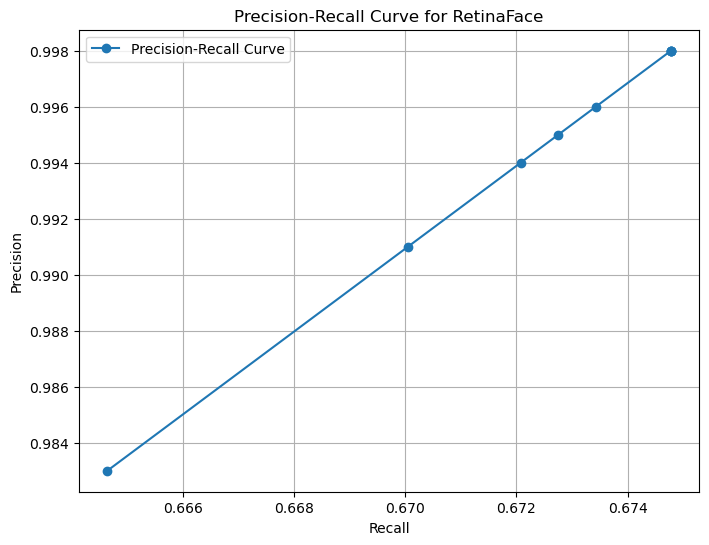

In [27]:
json_path = "Data/WIDER FACE Validation Set/wider_face_val_annotations.json"
iou_thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
output_path = "Outputs/precision_recall_scores.json"

precision_recall_curve_random(json_path, iou_thresholds, max_images=100, output_path=output_path)

## Visulizing the Results

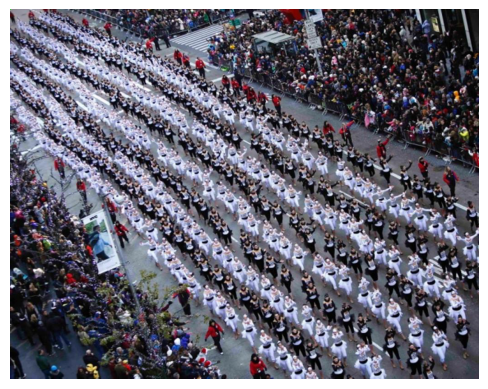

In [ ]:
import matplotlib.pyplot as plt

for gt_bbox in ground_truths:
    x1, y1, x2, y2 = gt_bbox
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Ground truth: Green

for pred_bbox in predictions:
    x1, y1, x2, y2 = pred_bbox
    cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Prediction: Blue

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

### Visualising the Number of Faces Metrics

In [ ]:
import json

difficulties = ["easy", "medium", "hard"]
num_faces_outputs = {}

for difficulty in difficulties:
    json_path = "Outputs/metrics_" + difficulty + "_num_faces.json"
    with open(json_path, 'r') as json_file:
        results = json.load(json_file)

    precision = results['mean_precision']
    recall = results['mean_recall']
    f1_score = results['mean_f1_score']

    metrics = [precision, recall, f1_score]
    num_faces_outputs[difficulty] = metrics

num_faces_outputs

{'easy': [0.9284016636957814, 0.9447415329768271, 0.9334224598930477],
 'medium': [0.9714176395994576, 0.8887358432812977, 0.9138885143017359],
 'hard': [0.9860869766549281, 0.6739649974105261, 0.7657071568357248]}

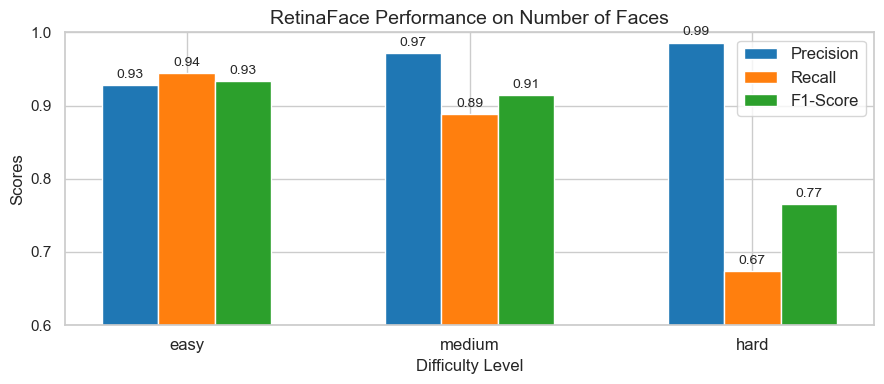

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

categories = list(num_faces_outputs.keys())
precision = [scores[0] for scores in num_faces_outputs.values()]
recall = [scores[1] for scores in num_faces_outputs.values()]
f1_score = [scores[2] for scores in num_faces_outputs.values()]

# Set the style
sns.set(style="whitegrid")

# Number of categories
n_categories = len(categories)

# Index for each category
ind = np.arange(n_categories)

# Width of each bar
width = 0.2

# Create the plot
fig, ax = plt.subplots(figsize=(9, 4))

# Plot each metric
bar1 = ax.bar(ind - width, precision, width, label='Precision', color='#1f77b4')
bar2 = ax.bar(ind, recall, width, label='Recall', color='#ff7f0e')
bar3 = ax.bar(ind + width, f1_score, width, label='F1-Score', color='#2ca02c')

# Add labels, title, and custom x-axis tick labels
ax.set_xlabel('Difficulty Level', fontsize=12)
ax.set_ylabel('Scores', fontsize=12)
ax.set_title('RetinaFace Performance on Number of Faces', fontsize=14)
ax.set_xticks(ind)
ax.set_xticklabels(categories, fontsize=12)
ax.set_ylim(0.6, 1.0)  # Set y-axis from 0.6 to 1.0
ax.set_yticks(np.arange(0.6, 1.01, 0.1))  # Set yticks at 0.6, 0.7, ..., 1.0
ax.legend(fontsize=12)

# Add value labels on top of each bar
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

add_labels(bar1)
add_labels(bar2)
add_labels(bar3)

# Adjust layout for better fit
plt.tight_layout()

# Show the plot
plt.show()

### Visualising the Blur Metrics

In [ ]:
import json

difficulties = ["easy", "medium", "hard"]
blur_outputs = {}

for difficulty in difficulties:
    json_path = "Outputs/metrics_" + difficulty + "_blur.json"
    with open(json_path, 'r') as json_file:
        results = json.load(json_file)

    precision = results['mean_precision']
    recall = results['mean_recall']
    f1_score = results['mean_f1_score']

    metrics = [precision, recall, f1_score]
    blur_outputs[difficulty] = metrics

blur_outputs

{'easy': [0.9588095238095236, 0.9696867370407741, 0.9602723003420476],
 'medium': [0.9599947156018583, 0.9290800747835886, 0.9381745917728048],
 'hard': [0.9675332921047207, 0.6375872766098781, 0.7346819623576817]}

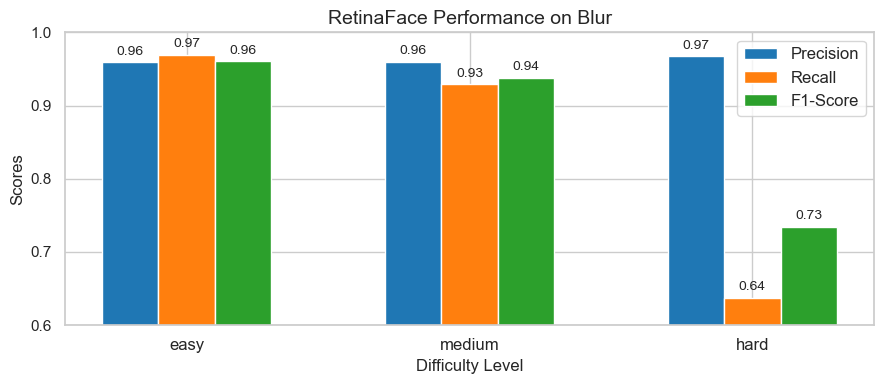

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

categories = list(blur_outputs.keys())
precision = [scores[0] for scores in blur_outputs.values()]
recall = [scores[1] for scores in blur_outputs.values()]
f1_score = [scores[2] for scores in blur_outputs.values()]

# Set the style
sns.set(style="whitegrid")

# Number of categories
n_categories = len(categories)

# Index for each category
ind = np.arange(n_categories)

# Width of each bar
width = 0.2

# Create the plot
fig, ax = plt.subplots(figsize=(9, 4))

# Plot each metric
bar1 = ax.bar(ind - width, precision, width, label='Precision', color='#1f77b4')
bar2 = ax.bar(ind, recall, width, label='Recall', color='#ff7f0e')
bar3 = ax.bar(ind + width, f1_score, width, label='F1-Score', color='#2ca02c')

# Add labels, title, and custom x-axis tick labels
ax.set_xlabel('Difficulty Level', fontsize=12)
ax.set_ylabel('Scores', fontsize=12)
ax.set_title('RetinaFace Performance on Blur', fontsize=14)
ax.set_xticks(ind)
ax.set_xticklabels(categories, fontsize=12)
ax.set_ylim(0.6, 1.0)  # Set y-axis from 0.6 to 1.0
ax.set_yticks(np.arange(0.6, 1.01, 0.1))  # Set yticks at 0.6, 0.7, ..., 1.0
ax.legend(fontsize=12)

# Add value labels on top of each bar
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

add_labels(bar1)
add_labels(bar2)
add_labels(bar3)

# Adjust layout for better fit
plt.tight_layout()

# Show the plot
plt.show()

### Visualising the Occlusion Metrics

In [7]:
import json

difficulties = ["easy", "medium", "hard"]
occlusion_outputs = {}

for difficulty in difficulties:
    json_path = "Outputs/metrics_" + difficulty + "_occlusion.json"
    with open(json_path, 'r') as json_file:
        results = json.load(json_file)

    precision = results['mean_precision']
    recall = results['mean_recall']
    f1_score = results['mean_f1_score']

    metrics = [precision, recall, f1_score]
    occlusion_outputs[difficulty] = metrics

occlusion_outputs

{'easy': [0.9712283549783549, 0.9656604599104598, 0.9647391548538609],
 'medium': [0.9409705942205941, 0.8431865893365893, 0.8749410996716036],
 'hard': [0.9811984126984127, 0.639758484263822, 0.7424608079037595]}

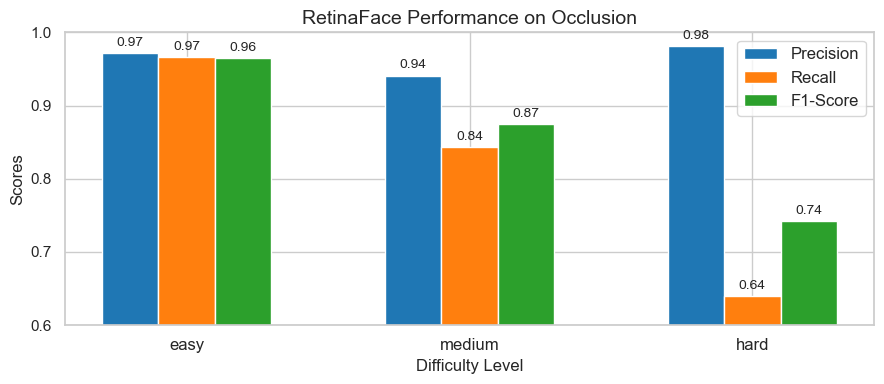

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

categories = list(occlusion_outputs.keys())
precision = [scores[0] for scores in occlusion_outputs.values()]
recall = [scores[1] for scores in occlusion_outputs.values()]
f1_score = [scores[2] for scores in occlusion_outputs.values()]

# Set the style
sns.set(style="whitegrid")

# Number of categories
n_categories = len(categories)

# Index for each category
ind = np.arange(n_categories)

# Width of each bar
width = 0.2

# Create the plot
fig, ax = plt.subplots(figsize=(9, 4))

# Plot each metric
bar1 = ax.bar(ind - width, precision, width, label='Precision', color='#1f77b4')
bar2 = ax.bar(ind, recall, width, label='Recall', color='#ff7f0e')
bar3 = ax.bar(ind + width, f1_score, width, label='F1-Score', color='#2ca02c')

# Add labels, title, and custom x-axis tick labels
ax.set_xlabel('Difficulty Level', fontsize=12)
ax.set_ylabel('Scores', fontsize=12)
ax.set_title('RetinaFace Performance on Occlusion', fontsize=14)
ax.set_xticks(ind)
ax.set_xticklabels(categories, fontsize=12)
ax.set_ylim(0.6, 1.0)  # Set y-axis from 0.6 to 1.0
ax.set_yticks(np.arange(0.6, 1.01, 0.1))  # Set yticks at 0.6, 0.7, ..., 1.0
ax.legend(fontsize=12)

# Add value labels on top of each bar
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

add_labels(bar1)
add_labels(bar2)
add_labels(bar3)

# Adjust layout for better fit
plt.tight_layout()

# Show the plot
plt.show()

### Visulising the Illumination Metrics

In [8]:
import json

difficulties = ["normal", "extreme"]
illumination_outputs = {}

for difficulty in difficulties:
    json_path = "Outputs/metrics_" + difficulty + "_illumination.json"
    with open(json_path, 'r') as json_file:
        results = json.load(json_file)

    precision = results['mean_precision']
    recall = results['mean_recall']
    f1_score = results['mean_f1_score']

    metrics = [precision, recall, f1_score]
    illumination_outputs[difficulty] = metrics

illumination_outputs

{'normal': [0.950811507936508, 0.848907244198213, 0.8771017758687722],
 'extreme': [0.9634263791763792, 0.7314188455307757, 0.7975998774947533]}

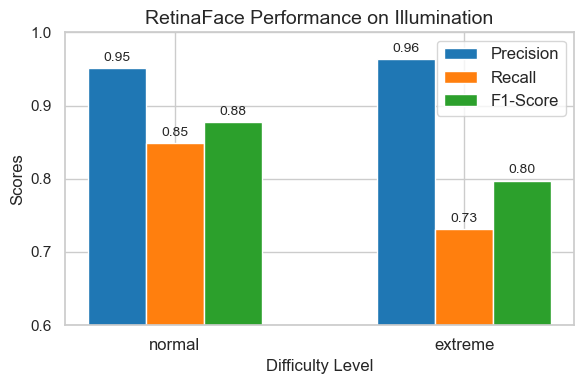

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

categories = list(illumination_outputs.keys())
precision = [scores[0] for scores in illumination_outputs.values()]
recall = [scores[1] for scores in illumination_outputs.values()]
f1_score = [scores[2] for scores in illumination_outputs.values()]

# Set the style
sns.set(style="whitegrid")

# Number of categories
n_categories = len(categories)

# Index for each category
ind = np.arange(n_categories)

# Width of each bar
width = 0.2

# Create the plot
fig, ax = plt.subplots(figsize=(6, 4))

# Plot each metric
bar1 = ax.bar(ind - width, precision, width, label='Precision', color='#1f77b4')
bar2 = ax.bar(ind, recall, width, label='Recall', color='#ff7f0e')
bar3 = ax.bar(ind + width, f1_score, width, label='F1-Score', color='#2ca02c')

# Add labels, title, and custom x-axis tick labels
ax.set_xlabel('Difficulty Level', fontsize=12)
ax.set_ylabel('Scores', fontsize=12)
ax.set_title('RetinaFace Performance on Illumination', fontsize=14)
ax.set_xticks(ind)
ax.set_xticklabels(categories, fontsize=12)
ax.set_ylim(0.6, 1.0)  # Set y-axis from 0.6 to 1.0
ax.set_yticks(np.arange(0.6, 1.01, 0.1))  # Set yticks at 0.6, 0.7, ..., 1.0
ax.legend(fontsize=12)

# Add value labels on top of each bar
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

add_labels(bar1)
add_labels(bar2)
add_labels(bar3)

# Adjust layout for better fit
plt.tight_layout()

# Show the plot
plt.show()

### Precision - Recall Curve

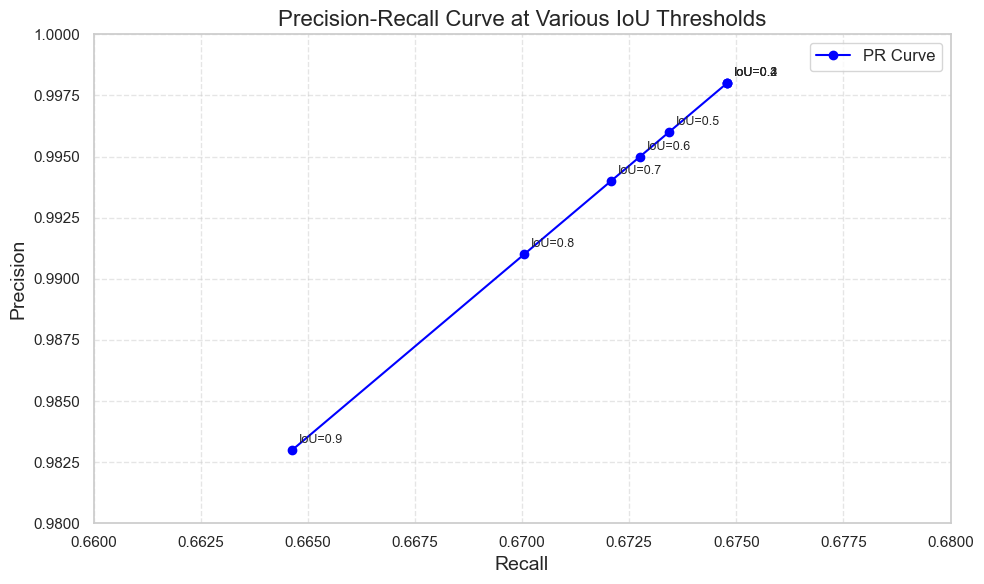

In [ ]:
import json

json_path = "Outputs/precision_recall_scores.json"

with open(json_path, 'r') as json_file:
    values = json.load(json_file)

iou_thresholds = values['iou_thresholds']
precision = values['precision']
recall = values['recall']

# Initialize the plot
plt.figure(figsize=(10, 6))

# Plot the PR Curve
plt.plot(recall, precision, marker='o', linestyle='-', color='blue', label='PR Curve')

# Annotate each point with its corresponding IoU threshold
for i, (r, p) in enumerate(zip(recall, precision)):
    plt.annotate(f'IoU={iou_thresholds[i]}', (r, p), textcoords="offset points", xytext=(5,5), ha='left', fontsize=9)

# Adding Titles and Labels
plt.title('Precision-Recall Curve at Various IoU Thresholds', fontsize=16)
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)

# Setting Axis Limits for Better Visualization
plt.xlim(0.66, 0.68)
plt.ylim(0.98, 1.00)

# Adding Grid for Readability
plt.grid(True, linestyle='--', alpha=0.5)

# Adding Legend
plt.legend(loc='best', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

## Inference Time

In [3]:
import time
import random
import cv2
from retinaface import RetinaFace
import json

def calculate_average_prediction_time(json_path, max_images=100, seed=42):
    """
    Calculate the average prediction time of the RetinaFace model on a random subset of images.

    Args:
        json_path (str): Path to the JSON file containing annotations.
        max_images (int): Number of images to process.
        seed (int): Random seed for reproducibility.

    Returns:
        float: The average prediction time per image in seconds.
    """
    # Load the annotations
    with open(json_path, 'r') as json_file:
        annotations = json.load(json_file)

    # Randomly select a subset of the data
    random.seed(seed)
    if len(annotations) > max_images:
        annotations_subset = random.sample(annotations, max_images)
    else:
        annotations_subset = annotations
        print(f"Warning: Dataset contains fewer than {max_images} images. Using all available images.")

    # Initialize the RetinaFace model
    retinaface_model = RetinaFace.build_model()

    # Measure prediction times
    prediction_times = []

    for image_annotation in annotations_subset:
        # Load the image
        image_path = image_annotation['image_path']
        image = cv2.imread(image_path)
        if image is None:
            print(f"Error: Could not load image at {image_path}")
            continue

        # Start the timer
        start_time = time.time()

        # Make predictions
        _ = RetinaFace.detect_faces(image, model=retinaface_model)

        # End the timer
        end_time = time.time()

        # Calculate prediction time
        prediction_time = end_time - start_time
        prediction_times.append(prediction_time)

    # Calculate the average prediction time
    if prediction_times:
        average_time = sum(prediction_times) / len(prediction_times)
        print(f"Average prediction time: {average_time:.4f} seconds per image")
        return average_time
    else:
        print("No valid images were processed.")
        return None

In [4]:
json_path = "Data/WIDER FACE Validation Set/wider_face_val_annotations.json"

calculate_average_prediction_time(json_path)

Average prediction time: 1.5967 seconds per image


1.5967222714424134